In [1]:
import numpy as np
import torch
import librosa
import librosa.display
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import os

from collections import defaultdict

import tqdm
sns.set()

import matplotlib.pyplot as plt
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.signal import convolve, fftconvolve
import utils

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer

In [3]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 5
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data = False

In [4]:
def show(audio):
    return Audio(audio, rate=conf.sampling_rate)

In [ ]:
conf.columns, conf.column_encoder = utils.read_columns()

In [ ]:
all_data, all_y, max_len = utils.read_dataset("./data/train_curated", conf, lambda s: s)

 66%|██████▌   | 3269/4970 [05:23<02:58,  9.52it/s]

In [ ]:
lengths = np.array(list([len(a) for a in all_data]))/conf.sampling_rate

In [157]:
np.quantile(lengths, 0.95)

24.36857256235829

In [158]:
all_data = np.array(all_data)

In [159]:
show(all_data[234] + 10 * all_data[1353] + all_data[1334] + 0.1 * np.random.randn(*all_data[0].shape))
# sound = all_data[234] + 10 * all_data[1353] + all_data[1334]
show(sound)

ValueError: operands could not be broadcast together with shapes (270847,) (88200,) 

In [448]:
all_rooms_meta, all_rooms = utils.read_filters("./filters/", conf, lambda s: s)

 55%|█████▍    | 40/73 [00:02<00:02, 16.48it/s]


KeyboardInterrupt: 

In [500]:
def apply_filter(sound, filter):
    modified_sound = fftconvolve(in2=filter, in1=sound) / np.linalg.norm(sound)
    return modified_sound

In [501]:
# for i in range(len(all_rooms)):
modified_sound = apply_filter(sound, all_rooms[0])
# show(modified_sound)
# s = utils.audio_to_melspectrogram(conf, modified_sound)

In [512]:
sound.shape

(498589,)

In [502]:
np.linalg.norm(sound)

20.68781161408502

In [503]:
np.linalg.norm(modified_sound)

0.7419629894010455

In [504]:
# modified_sound=librosa.effects.pitch_shift(sound, sr=conf.sampling_rate, n_steps=5)

In [505]:
show(modified_sound)

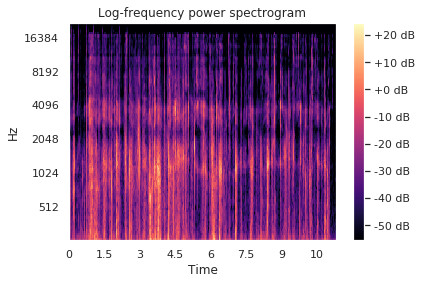

In [506]:
utils.show_melspectrogram(conf, utils.audio_to_melspectrogram(conf, sound))

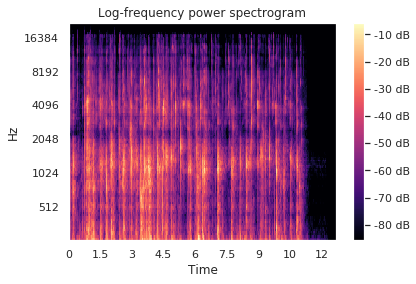

In [507]:
utils.show_melspectrogram(conf, utils.audio_to_melspectrogram(conf, modified_sound))

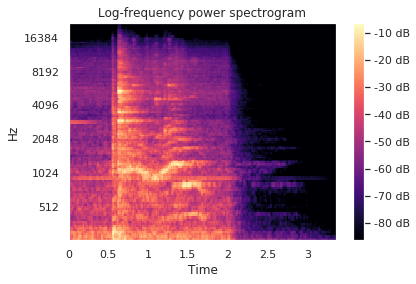

In [103]:
utils.show_melspectrogram(conf, utils.audio_to_melspectrogram(conf, modified_sound))

In [111]:
modified_sound = librosa.effects.percussive(sound)

In [112]:
show(modified_sound)

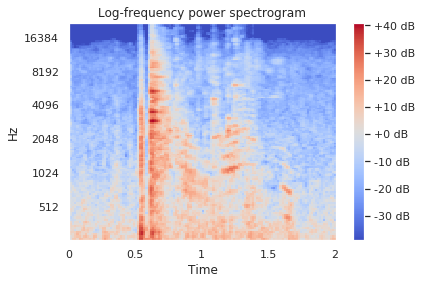

In [106]:
utils.show_melspectrogram(conf, utils.audio_to_melspectrogram(conf, modified_sound))

In [107]:
modified_sound = librosa.effects.harmonic(sound)

In [108]:
show(modified_sound)

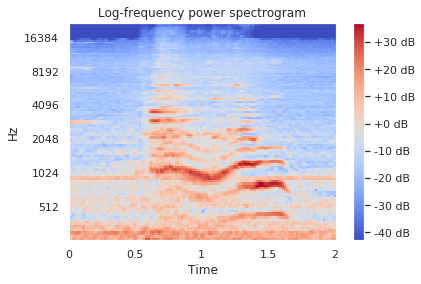

In [109]:
utils.show_melspectrogram(conf, utils.audio_to_melspectrogram(conf, modified_sound))

In [110]:
show(sound)

In [120]:
modified_sound = librosa.effects.time_stretch(sound, 0.4)

In [126]:
show(modified_sound)

In [123]:
modified_sound.shape

(221184,)

In [134]:
# train_dataset = trainer.SoundAugDataset(all_data, all_y, lambda s: s, max_size=10000, max_n_mixed=3, seed=42)

In [260]:
show(train_dataset[0]['x'])

In [535]:
train_dataset = trainer.SoundAugDataset(all_data, all_y, 
                                        transform = lambda s: utils.audio_to_melspectrogram(conf, s),
                                        room_filters=all_rooms, 
                                        params={
                                                    "max_size":10000,
                                                    "max_n_mixed":3,
                                                    "change_pitch":0.1,
                                                    "change_pitch_max":1,
                                                    "add_echo":1.0,
                                                    "harmonic_percussive":0.1,
                                                    "noise_magnitude":0.00005
                                               },
                                        config=conf,
                                        seed=42)

In [536]:
item = train_dataset[0]


In [537]:
show(item['raw_x'])

In [516]:
item['ids'], item['coefs']

([3772, 466, 3444], array([0.53338692, 0.39966715, 0.06694593]))

In [517]:
show(all_data[2734])

In [538]:
aug_coll = trainer.AugmentationCollator(conf, None)

In [539]:
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=aug_coll, shuffle=True, num_workers=0)

In [540]:
for b in train_loader:
    break

In [546]:
show(b['raw_x'][26])

In [547]:
b['x'][26]

tensor([[-32.4747, -24.6831, -18.9040,  ..., -52.1717, -52.1717, -52.1717],
        [-11.0833,  -8.4481,  -7.4949,  ..., -52.1717, -52.1717, -52.1717],
        [ 12.9020,  16.3625,  17.3845,  ..., -52.1717, -52.1717, -52.1717],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]])

In [550]:
def construct_mask(in_channels, out_channels, bandwidth, overlap):
    a = np.arange(1, bandwidth + 1)
    g = np.arange(1, int(np.ceil((in_channels * out_channels) / (in_channels + bandwidth - overlap))) + 1)

    mask = np.zeros((in_channels * out_channels))

    for i in range(len(a)):
        for j in range(len(g)):
            lx = a[i] + (g[j] - 1) * (in_channels + bandwidth - overlap)
            if lx <= in_channels * out_channels:
                mask[lx - 1] = 1

    binary_mask =  mask.reshape(out_channels, in_channels).T

    return binary_mask.astype(np.float32)

In [566]:
m = construct_mask(256, 1024, 64, 16)

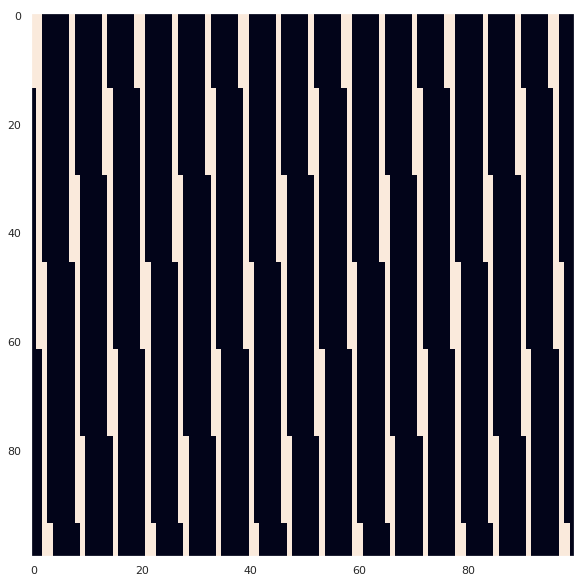

In [573]:
plt.figure(figsize=(15, 10))
plt.imshow(m[50:150, 0:100])
plt.grid(False)

In [599]:
z = torch.nn.Conv1d(128, 3, 14)

In [600]:
f1 = z(b['x'].permute(0, 2, 1))

In [601]:
f2 = torch.nn.functional.conv1d(b['x'].permute(0, 2, 1), weight=z.weight, bias=z.bias, stride=z.stride, padding=z.padding, dilation=z.dilation, groups=z.groups)

In [602]:
z.weight.shape

torch.Size([3, 128, 14])

In [603]:
b['x'].shape

torch.Size([64, 197, 128])